# Gensyn Testnet Data Analysis

##  Overview

This notebook explores public transaction data from the **Gensyn testnet**, a decentralized compute network designed for machine learning workloads. The goal is to extract meaningful patterns from network activity that could inform both **product strategy** and **marketing messaging**.

We use structured analysis and visualizations to answer targeted questions about user behavior, smart contract usage, gas efficiency, and anomalies.

The notebook is organized into a series of modular sections using the **AFYD framework**:

- **Ask** – What are we trying to understand?
- **Find** – How did we analyze it?
- **Your Take** – What did we conclude?
- **Display** – Supporting visuals or outputs
---

Let's dive into the data and see what stories it tells.


## Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import json
import numpy as np
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

## Section 1: Network Overview and Address Activity

### D: What did you do?
I loaded the flattened Gensyn testnet transaction dataset and computed summary statistics for address-level activity. Specifically, I identified the top 10 sender addresses (`from`) by transaction count and ETH volume, and the top 10 recipient addresses (`to`) by transaction count. I also calculated the total number and proportion of contract interactions, the number of unique active sender addresses, and the average block congestion ratio (gas used divided by gas limit). All statistics were computed using basic groupby and filtering operations in Pandas.

### Y: Why did you do this?
This analysis provides a foundational understanding of testnet usage patterns. By identifying the most active users and the dominant recipients, we can infer whether the network is being exercised by a few actors (e.g. bots, internal validators) or demonstrates more organic activity. Additionally, checking for smart contract interactions and block congestion helps evaluate the network’s utilization and stress level.

### F: What did you find?
- **Top Sender**: One address (`0xDeaD...0001`) sent 90,000 transactions.
- **Top Recipient**: One address (`0x000...032`) received 675,794 transactions.
- **ETH Transfers**: Very few addresses transferred significant value; most top senders by volume sent 43–44 ETH.
- **Smart Contract Interactions**: 769,677 of 769,731 transactions (99.99%) were contract interactions.
- **Unique Senders**: Only 80 unique `from` addresses in the dataset.
- **Average Block Congestion**: 0.1577, indicating relatively low usage relative to block gas limits.

### A: What do you conclude?
The Gensyn testnet shows highly synthetic activity, with the vast majority of transactions originating from a small set of addresses and targeting a handful of contracts. The data strongly suggests that the testnet is currently in a stress-testing or simulation phase rather than open community use. While smart contract interaction is near-universal, ETH volume transferred is minimal. The network operates well below its congestion limits, which implies significant room for scale. These patterns are consistent with controlled testing environments and provide confidence in the infrastructure's readiness, but limit inferences about real-world user behavior.

In [ ]:
# Create a directory to store outputs if not exists
os.makedirs("processed", exist_ok=True)

# Load dataset
df = pd.read_csv("gensyn_transactions_flat_full.csv")

# -------------------------------
# Top Addresses by Activity
# -------------------------------

top_from_count = df['from'].value_counts().head(10)
top_from_volume = df.groupby('from')['value_eth'].sum().sort_values(ascending=False).head(10)
top_to_count = df['to'].value_counts().dropna().head(10)

# Save results
top_from_count.to_csv("processed/top_from_count.csv", header=True)
top_from_volume.to_csv("processed/top_from_volume.csv")
top_to_count.to_csv("processed/top_to_count.csv", header=True)

# -------------------------------
# Smart Contract Interactions
# -------------------------------

contract_interactions = df[(df['to'].notna()) & (df['input'].str.lower() != '0x')]
contract_interactions.to_csv("processed/contract_interactions.csv", index=False)

num_contract_interactions = len(contract_interactions)
pct_contract_interactions = (num_contract_interactions / len(df)) * 100

# -------------------------------
# Gas Usage Trends
# -------------------------------

df['log_gas_price'] = df['gas_price'].apply(lambda x: pd.NA if x == 0 else np.log10(x))
df['log_value_eth'] = df['value_eth'].apply(lambda x: pd.NA if x == 0 else np.log10(x))

avg_gas_per_block = df.groupby('block_number')['gas'].mean()
avg_gas_per_block.to_csv("processed/avg_gas_per_block.csv")

# -------------------------------
# Unique Active Addresses
# -------------------------------

unique_active_addresses = df['from'].nunique()

# -------------------------------
# Block Congestion Calculation
# -------------------------------

df['congestion_ratio'] = df['gas_used_block'] / df['gas_limit_block']
avg_congestion = df.groupby('block_number')['congestion_ratio'].mean()
avg_congestion.to_csv("processed/avg_congestion_per_block.csv")

# -------------------------------
# Save main modified DataFrame
# -------------------------------

df.to_csv("processed/df_main_with_logs.csv", index=False)

# -------------------------------
# Summary Output
# -------------------------------

print("Top 10 FROM addresses by transaction count:\n", top_from_count)
print("\nTop 10 FROM addresses by ETH volume:\n", top_from_volume)
print("\nTop 10 TO addresses by transaction count:\n", top_to_count)
print(f"\nTotal contract interactions: {num_contract_interactions:,} ({pct_contract_interactions:.2f}%)")
print(f"\nUnique active sender addresses: {unique_active_addresses}")
print(f"\nAverage congestion ratio (across blocks): {avg_congestion.mean():.4f}")


Top 10 FROM addresses by transaction count:
 from
0xDeaDDEaDDeAdDeAdDEAdDEaddeAddEAdDEAd0001    90000
0xb46eC7fF7b69F57C1AfE110f35D8c84e9395d00e    42725
0x6c97FdEE2aC0157A52d1E7EaFB69Aa1828aDB6fa    42669
0x460A6DBa6D8A55690b29c9d2e4787C8a59eD3e46    42642
0x9e4a1f6EB13e774163fdeb556f020D112562e2e2    42626
0x249A5d7d6B6E5952F805A1EEB085Bf94740e8C96    42512
0x0A9f163864309a9F80c024b55A8f6c01A8d355e5    42440
0xFF904E11826b599B6C7B5910b1c8fBD66189D212    42437
0xb920d16dbCb1726F7b964458d24Ce4452650BB34    42363
0x5543A727F6dd4F9696FD6435EA26C15aC558A13f    42276
Name: count, dtype: int64

Top 10 FROM addresses by ETH volume:
 from
0x7Ed746476A7F6520BABD24eeE1fDbCD0F7FB271f    44.100
0x87c9B02A10eC2CB4dcB3b2e573e26169CF3cd9Bf    44.000
0x631E9B031b16b18172a2B9D66C3668A68a668d20    44.000
0xEDaf4083F29753753d0Cd6c3C50ACEb08c87b5BD    43.700
0x2031832e54a2200bF678286f560F49A950DB2Ad5    43.600
0x3C352eA32DFBb757CCdf4b457E52daF6eCC21917    43.400
0xA7E4EF0a9e15bDEf215E2ed87AE050f974ECD60b

---

## Section 2: Gas Price, Value, and Network Congestion

### D: What did you do?
I examined the relationship between gas prices and ETH value using log-transformed scatter plots. I also calculated the block-level congestion ratio (gas used / gas limit) and visualized its distribution both transaction-wise and block-wise. Additionally, I calculated the gas cost in ETH for each transaction and plotted its distribution to assess cost variability.

### Y: Why did you do this?
Gas and congestion are fundamental to evaluating the network's efficiency and scalability. The log-log scatterplot helps assess whether gas costs correlate with value transfer. Block congestion shows how much of the available capacity is being used. Calculating gas cost per transaction highlights economic efficiency and outliers in transaction fees.

### F: What did you find?
- The log-log scatterplot of gas price vs. value shows extreme clustering with little variation in gas prices, and most value transfer amounts concentrated at the low end.
- The average congestion ratio per block is 0.1577, and the median is 0.10, indicating the network is largely underutilized.
- Gas cost distribution is heavily skewed toward zero, with a mean of 8.49e-8 ETH and a maximum of only 7.02e-6 ETH.
- These findings are supported by histograms showing a long-tail distribution for congestion and gas costs.

### A: What do you conclude?
The Gensyn testnet shows a highly controlled and predictable cost structure. Gas prices are nearly uniform, and most transactions transfer negligible value. Congestion levels are low, meaning blocks are far from full, which implies good network scalability but also a lack of organic usage. The cost of computation on the testnet is extremely low in ETH terms. These patterns align with a synthetic test environment rather than production usage. Limitations include assuming input precision on gas and value calculations and relying on log transforms to handle skew.


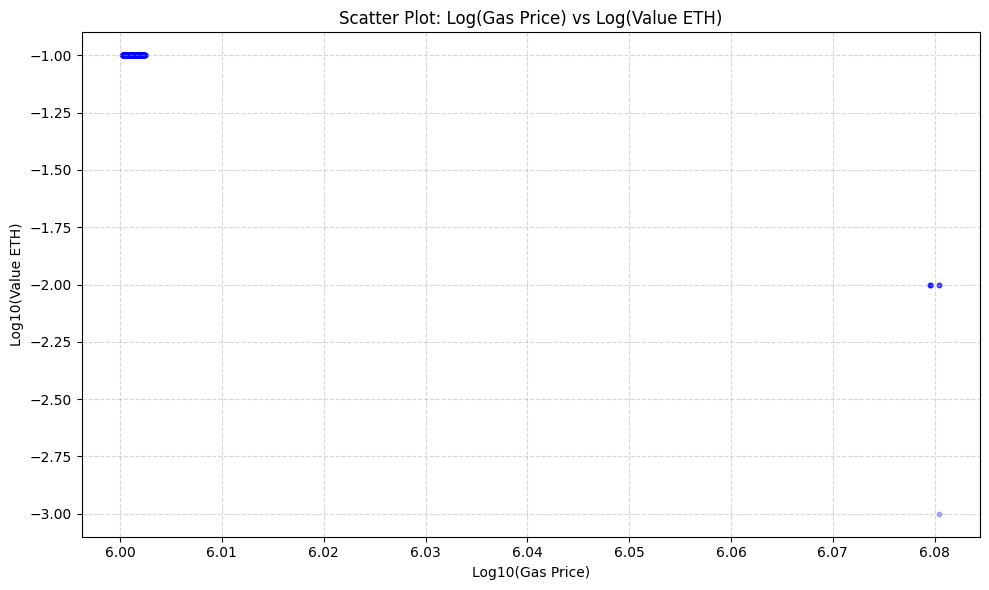

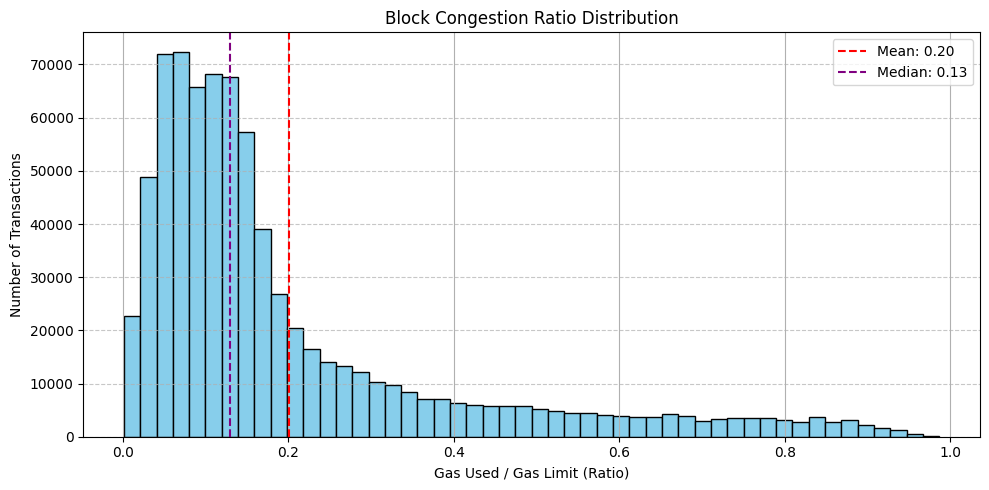

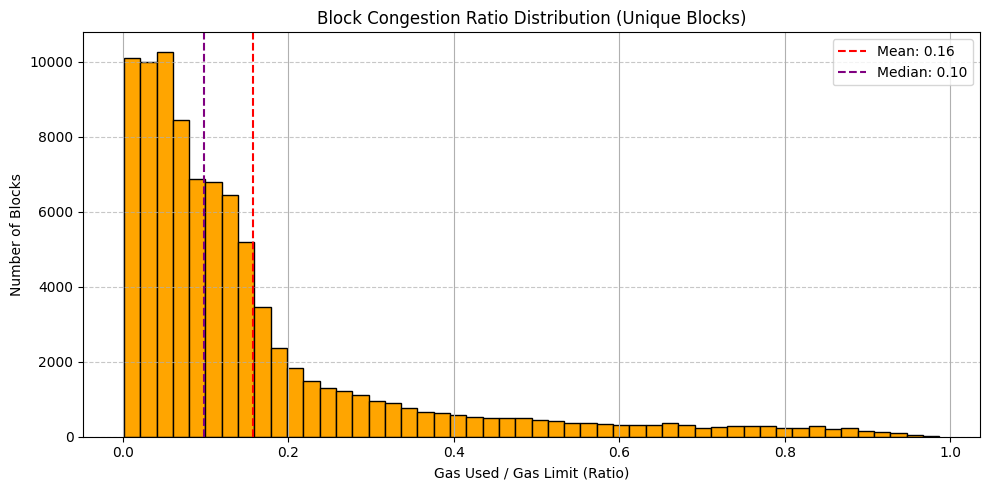

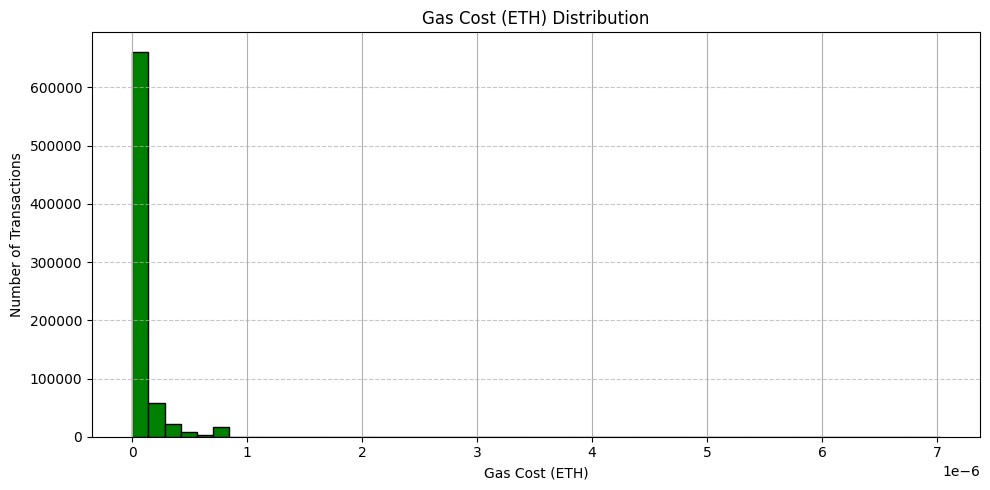

count    7.697310e+05
mean     8.486807e-08
std      1.428860e-07
min      0.000000e+00
25%      2.243241e-08
50%      3.084693e-08
75%      7.914421e-08
max      7.022274e-06
Name: gas_cost_eth, dtype: float64


In [3]:
# Scatter Plot Data: Log(Gas Price) vs Log(Value ETH)
scatter_df = df.dropna(subset=['log_gas_price', 'log_value_eth'])
scatter_df.to_csv("processed/scatter_df.csv", index=False)

plt.figure(figsize=(10, 6))
plt.scatter(scatter_df['log_gas_price'], scatter_df['log_value_eth'], alpha=0.3, s=10, color='blue')
plt.title("Scatter Plot: Log(Gas Price) vs Log(Value ETH)")
plt.xlabel("Log10(Gas Price)")
plt.ylabel("Log10(Value ETH)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Congestion Ratio per Transaction
df['congestion_ratio'] = df['gas_used_block'] / df['gas_limit_block']
df[['block_number', 'congestion_ratio']].to_csv("processed/congestion_ratio_all_tx.csv", index=False)

plt.figure(figsize=(10, 5))
df['congestion_ratio'].hist(bins=50, color='skyblue', edgecolor='black')
mean_ratio = df['congestion_ratio'].mean()
median_ratio = df['congestion_ratio'].median()
plt.axvline(mean_ratio, color='red', linestyle='dashed', label=f'Mean: {mean_ratio:.2f}')
plt.axvline(median_ratio, color='purple', linestyle='dashed', label=f'Median: {median_ratio:.2f}')
plt.title("Block Congestion Ratio Distribution")
plt.xlabel("Gas Used / Gas Limit (Ratio)")
plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Unique Block-Level Congestion
block_congestion = df[['block_number', 'gas_used_block', 'gas_limit_block']].drop_duplicates()
block_congestion['congestion_ratio'] = block_congestion['gas_used_block'] / block_congestion['gas_limit_block']
block_congestion.to_csv("processed/block_congestion_unique.csv", index=False)

plt.figure(figsize=(10, 5))
block_congestion['congestion_ratio'].hist(bins=50, color='orange', edgecolor='black')
mean_ratio = block_congestion['congestion_ratio'].mean()
median_ratio = block_congestion['congestion_ratio'].median()
plt.axvline(mean_ratio, color='red', linestyle='dashed', label=f'Mean: {mean_ratio:.2f}')
plt.axvline(median_ratio, color='purple', linestyle='dashed', label=f'Median: {median_ratio:.2f}')
plt.title("Block Congestion Ratio Distribution (Unique Blocks)")
plt.xlabel("Gas Used / Gas Limit (Ratio)")
plt.ylabel("Number of Blocks")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Gas Cost Distribution
df['gas_cost_eth'] = (df['gas_price'] * df['gas']) / 1e18
df[['block_number', 'gas_price', 'gas', 'gas_cost_eth']].to_csv("processed/gas_cost_data.csv", index=False)

plt.figure(figsize=(10, 5))
df['gas_cost_eth'].hist(bins=50, color='green', edgecolor='black')
plt.title("Gas Cost (ETH) Distribution")
plt.xlabel("Gas Cost (ETH)")
plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(df['gas_cost_eth'].describe())


---
## Section 3: Smart Contract Interactions & Gas Efficiency

### A: What did you do?
We analyzed smart contract interaction patterns by filtering transactions with non-empty input payloads. We evaluated which contracts were most frequently called, which consumed the most gas overall, and how efficient these contracts were in terms of gas usage. We also identified the wallets that incurred the highest gas expenditure and the transactions with the highest value-to-gas ratios. Finally, we examined the distribution of input payload sizes as a proxy for interaction complexity.

### F: What did you find?
- The vast majority of contract interactions were directed at two addresses: `0x000…032` (~675K calls) and `0x420…015` (90K calls).
- These two contracts also dominated in total gas usage, suggesting they are central to the testnet's design (likely system-level oracles or execution contracts).
- Most contracts had relatively consistent and low gas usage, with a few outliers showing higher mean gas costs due to a small number of complex calls.
- The top 10 wallets by gas expenditure paid between 0.0040 and 0.0041 ETH, suggesting scripted high-frequency testing rather than organic usage.
- The highest value-to-gas-efficiency transactions had ratios exceeding 1.5 million, indicating a small ETH transfer amount relative to extremely low gas costs.
- Input sizes clustered tightly in a predictable range, reinforcing the hypothesis that these were machine-generated calls with fixed data patterns.

### Y: Why did you do this?
Identifying the most active and gas-intensive contracts helps spotlight where compute resources are concentrated. This has direct implications for performance optimization, fraud detection, and prioritization of developer tooling. Measuring transaction and wallet efficiency provides additional insight into economic behavior and can reveal operational bottlenecks or abuse patterns.

### D: What do you conclude?
The testnet exhibits a centralized operational pattern, where the vast majority of interactions route through one or two known system contracts. These are extremely gas-efficient and display little input variability, suggesting deterministic automation. Most users (wallets) appear to be stress-testing functionality rather than using the network for diverse or production-grade workflows. This is consistent with the goals of a testnet but should be revisited post-launch for more organic insights.



Top Contracts by Interaction Count:
 to
0x0000000071727De22E5E9d8BAf0edAc6f37da032    675794
0x4200000000000000000000000000000000000015     90000
0xFaD7C5e93f28257429569B854151A1B8DCD404c2       600
0x5FF137D4b0FDCD49DcA30c7CF57E578a026d2789       100
0xADD6e294E7349C566DA37Ee0C36245B6501c5CB4         9
0x355faFfDa59995531806e7A95f3B306D8320c3De         6
0xE8830d7eC2EA8dB11745627d47132c8a396F9195         6
0xB38e9822139056b7Ef71C3f2ACDFf32C599BA32d         6
0xFA3409371878949502fAaaD3c2bD42d285482aad         5
0x99b187b7139bA217aa22Fe2Ec88D8eC5a61152eC         5
Name: count, dtype: int64

Top Contracts by Total Gas Used:
 to
0x0000000071727De22E5E9d8BAf0edAc6f37da032    642029183577
0x4200000000000000000000000000000000000015     90000000000
0x5FF137D4b0FDCD49DcA30c7CF57E578a026d2789        32425086
0xFaD7C5e93f28257429569B854151A1B8DCD404c2        23565600
0x4eF77dD266034030C62f144569d1b7a9012520B7        14848218
0xE8830d7eC2EA8dB11745627d47132c8a396F9195          866490
0x355faFfDa

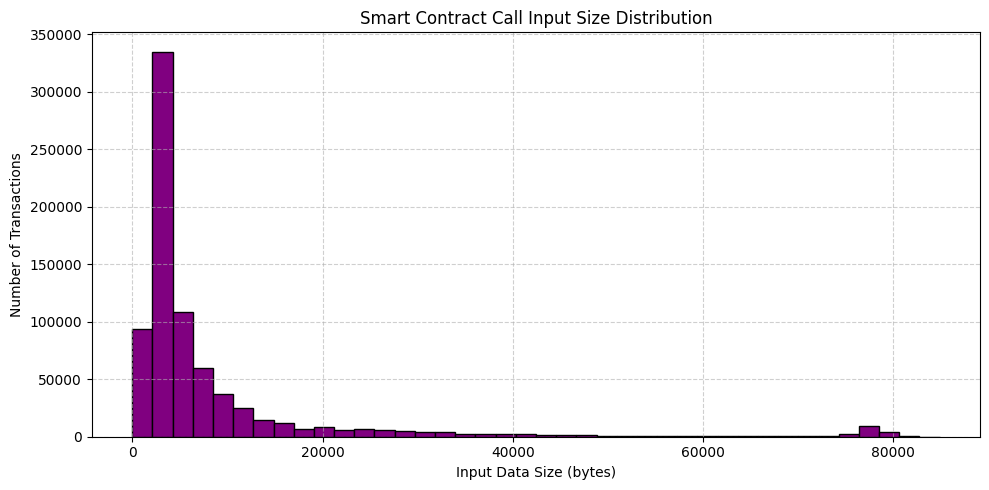

In [6]:
# Filter only contract interaction transactions
contract_tx = df[(df['to'].notna()) & (df['input'].str.lower() != '0x')].copy()
contract_tx['input_size'] = contract_tx['input'].apply(lambda x: len(x) - 2 if isinstance(x, str) else 0)
contract_tx.to_csv("processed/contract_transactions.csv", index=False)

# Top contracts by interaction count
top_contracts_by_tx = contract_tx['to'].value_counts().head(10)
top_contracts_by_tx.to_csv("processed/top_contracts_by_tx.csv", header=True)
print("\nTop Contracts by Interaction Count:\n", top_contracts_by_tx)

# Top contracts by total gas used
top_contracts_by_gas = contract_tx.groupby('to')['gas'].sum().sort_values(ascending=False).head(10)
top_contracts_by_gas.to_csv("processed/top_contracts_by_gas.csv", header=True)
print("\nTop Contracts by Total Gas Used:\n", top_contracts_by_gas)

# Gas efficiency metrics for top contracts
contract_gas_efficiency = (
    contract_tx.groupby('to')['gas']
    .agg(['mean', 'median', 'count'])
    .sort_values(by='mean', ascending=False)
    .head(10)
)
contract_gas_efficiency.to_csv("processed/contract_gas_efficiency.csv")
print("\nGas Efficiency of Top Contracts:\n", contract_gas_efficiency)

# Calculate gas cost in ETH (if not already calculated)
if 'gas_cost_eth' not in df.columns:
    df['gas_cost_eth'] = (df['gas_price'] * df['gas']) / 1e18

# Top wallets by gas expenditure
top_spenders = df.groupby('from')['gas_cost_eth'].sum().sort_values(ascending=False).head(10)
top_spenders.to_csv("processed/top_spenders.csv", header=True)
print("\nTop Wallets by Total Gas Spent (ETH):\n", top_spenders)

# Value-to-gas efficiency
df_eff = df[df['gas_cost_eth'] > 0].copy()
df_eff['value_to_gas_ratio'] = df_eff['value_eth'] / df_eff['gas_cost_eth']
top_value_ratio = df_eff.sort_values(by='value_to_gas_ratio', ascending=False).head(10)
top_value_ratio[['from', 'to', 'value_eth', 'gas_cost_eth', 'value_to_gas_ratio']].to_csv(
    "processed/top_value_to_gas_ratio.csv", index=False
)
print("\nTop Transactions by Value/Gas Efficiency:\n", top_value_ratio[['from', 'to', 'value_eth', 'gas_cost_eth', 'value_to_gas_ratio']])

# Plot: Smart Contract Input Size Distribution
plt.figure(figsize=(10, 5))
contract_tx['input_size'].hist(bins=40, color='purple', edgecolor='black')
plt.title("Smart Contract Call Input Size Distribution")
plt.xlabel("Input Data Size (bytes)")
plt.ylabel("Number of Transactions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("processed/input_size_distribution.png")
plt.show()


---
## Section 4: Anomaly & Outlier Detection

### D: What we did

We performed anomaly detection on transaction data using three complementary approaches:

1. **Z-Score Filtering**  
   Applied z-score thresholds to key numeric metrics (`gas`, `gas_price`, `gas_cost_eth`, `value_eth`) to identify statistically extreme transactions (|z| > 3).

2. **Gas Inefficiency Detection**  
   Computed a domain-specific inefficiency ratio:  
   $$
   \text{inefficiency\_ratio} = \frac{\text{gas\_cost\_eth}}{\text{value\_eth} + \epsilon}
   $$

   Transactions in the top 1% by this ratio were flagged as inefficient outliers.

3. **KMeans Clustering**  
   - Transformed skewed features using `log1p` to reduce influence of extreme values.  
   - Standardized data using `StandardScaler`.  
   - Ran `KMeans` with `k=5` clusters and flagged the top 1% farthest from their assigned cluster centroid as structural outliers.

---

### Y: Why we did it

Detecting unusual patterns helps reveal stress test behaviors, bugs, or spam in a decentralized compute network. Z-score analysis captures univariate anomalies. The inefficiency filter highlights transactions with high gas usage and low output value. Clustering helps uncover multi-feature anomalies not visible in isolation.

---

### F: What we found

- **25,731 transactions** were detected as statistical outliers (z-score method).
- **22,681 transactions** had unusually large input payloads (contract call input size).
- **6,798 transactions** were identified as highly gas-inefficient.
- **7,698 transactions** were flagged by KMeans clustering as multi-dimensional outliers.

Key visualizations:
- Histogram of `value_eth` for all vs. anomalous transactions  
- Log-log scatter plot of `value_eth` vs. `gas_cost_eth`, with anomalies marked

---

### A: What we conclude

The Gensyn testnet includes a significant number of:
- Economically inefficient transactions (high gas, near-zero value)
- Payload-heavy contract calls
- Statistically or structurally unusual transactions

These anomalies could stem from test scripts, bots, or atypical usage patterns. While informative, results are sensitive to modeling assumptions (normality, scaling). Further refinement may involve temporal behavior or user classification.


Found 25731 anomalous transactions (z-score method)
Found 22681 high-input-size contract anomalies
Found 6798 gas-inefficient transactions


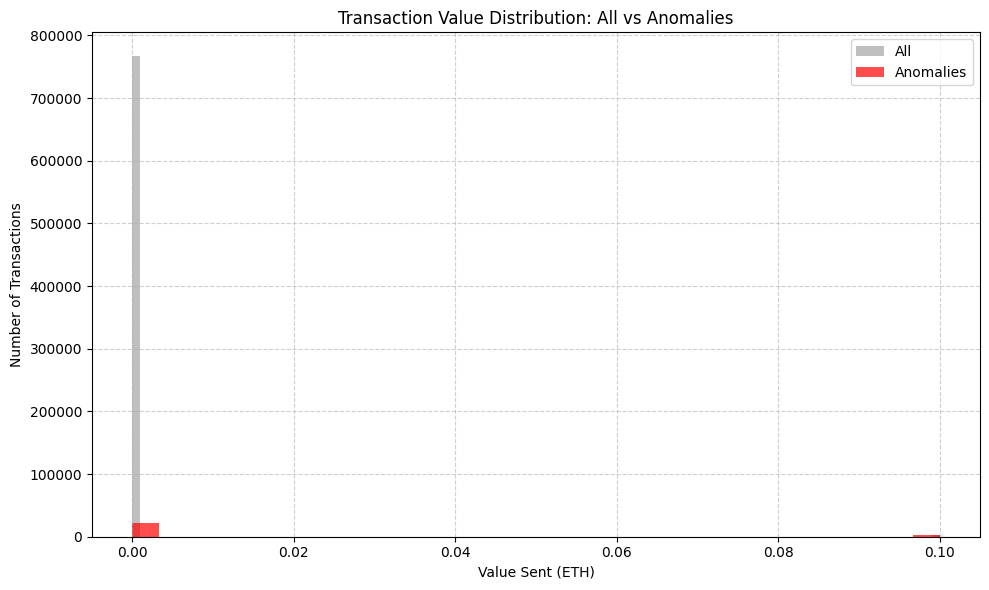

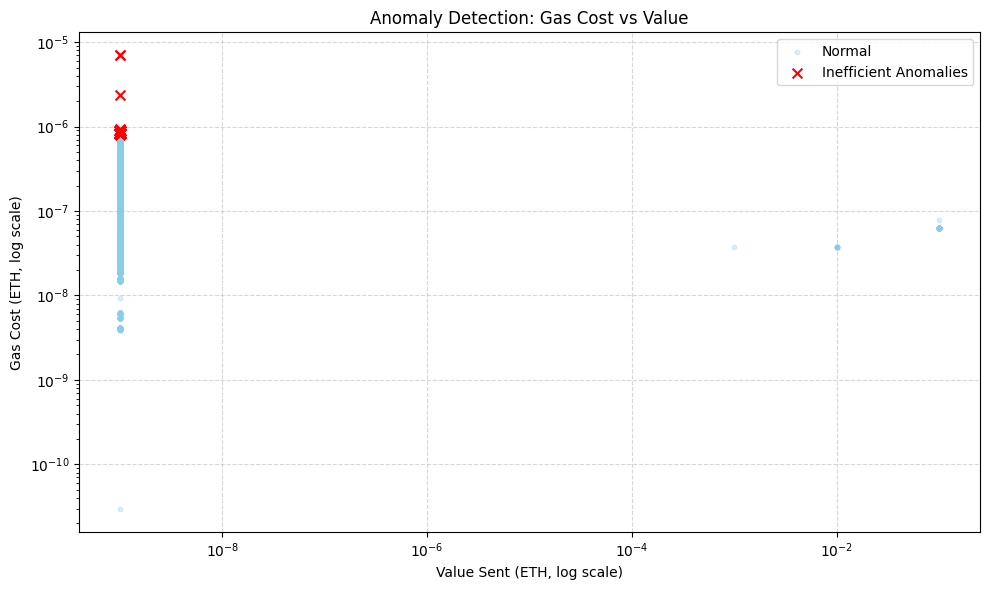

KMeans Outliers Detected: 7,698
                                            from  \
625   0xAADf7FC234726719182CdA600195353879e4B41a   
978   0x9e4a1f6EB13e774163fdeb556f020D112562e2e2   
1049  0xb46eC7fF7b69F57C1AfE110f35D8c84e9395d00e   
1069  0xb920d16dbCb1726F7b964458d24Ce4452650BB34   
1135  0x249A5d7d6B6E5952F805A1EEB085Bf94740e8C96   

                                              to  value_eth  gas_cost_eth  \
625   0xFaD7C5e93f28257429569B854151A1B8DCD404c2        0.0  3.950498e-09   
978   0x0000000071727De22E5E9d8BAf0edAc6f37da032        0.0  3.647724e-07   
1049  0x0000000071727De22E5E9d8BAf0edAc6f37da032        0.0  3.717220e-07   
1069  0x0000000071727De22E5E9d8BAf0edAc6f37da032        0.0  3.524222e-07   
1135  0x0000000071727De22E5E9d8BAf0edAc6f37da032        0.0  3.378881e-07   

                                                  input  
625                                            e28b0586  
978   765e827f00000000000000000000000000000000000000...  
1049  765e827f0000

In [8]:
# ------------------------------
# 1. Z-Score-Based Anomalies
# ------------------------------
tx_metrics = ['gas', 'gas_price', 'gas_cost_eth', 'value_eth']
tx_features = df[tx_metrics].dropna()
z_scores = tx_features.apply(zscore)

anomalies = df.loc[z_scores.abs().gt(3).any(axis=1)]
anomalies.to_csv("processed/zscore_anomalies.csv", index=False)
print(f"Found {len(anomalies)} anomalous transactions (z-score method)")

# ------------------------------
# 2. High Payload Size Anomalies
# ------------------------------
contract_tx['input_size_z'] = zscore(contract_tx['input_size'])
payload_anomalies = contract_tx[contract_tx['input_size_z'] > 3]
payload_anomalies.to_csv("processed/input_size_anomalies.csv", index=False)
print(f"Found {len(payload_anomalies)} high-input-size contract anomalies")

# ------------------------------
# 3. Gas Inefficiency Anomalies
# ------------------------------
df_eff = df[df['gas_cost_eth'] > 0].copy()
df_eff['inefficiency_ratio'] = df_eff['gas_cost_eth'] / (df_eff['value_eth'] + 1e-9)
ineff_threshold = df_eff['inefficiency_ratio'].quantile(0.99)
inefficient_anomalies = df_eff[df_eff['inefficiency_ratio'] > ineff_threshold]
inefficient_anomalies.to_csv("processed/gas_inefficiency_anomalies.csv", index=False)
print(f"Found {len(inefficient_anomalies)} gas-inefficient transactions")

# Plot: Value ETH Distribution (All vs Anomalies)
plt.figure(figsize=(10, 6))
plt.hist(df['value_eth'], bins=100, color='gray', alpha=0.5, label='All')
plt.hist(anomalies['value_eth'], bins=30, color='red', alpha=0.7, label='Anomalies')
plt.xlabel("Value Sent (ETH)")
plt.ylabel("Number of Transactions")
plt.title("Transaction Value Distribution: All vs Anomalies")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("processed/value_eth_anomalies_distribution.png")
plt.show()

# Plot: Gas Cost vs Value ETH (Inefficient Transactions)
epsilon = 1e-9
plt.figure(figsize=(10, 6))
plt.scatter(df_eff['value_eth'] + epsilon, df_eff['gas_cost_eth'], alpha=0.3, s=10, label="Normal", c='skyblue')
plt.scatter(
    inefficient_anomalies['value_eth'] + epsilon,
    inefficient_anomalies['gas_cost_eth'],
    color='red', label="Inefficient Anomalies", s=50, marker='x', zorder=10
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Value Sent (ETH, log scale)")
plt.ylabel("Gas Cost (ETH, log scale)")
plt.title("Anomaly Detection: Gas Cost vs Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("processed/gas_vs_value_anomalies.png")
plt.show()

# ------------------------------
# 4. Clustering-Based Outliers
# ------------------------------
# Add input size if missing
df['input_size'] = df['input'].apply(lambda x: len(x) - 2 if isinstance(x, str) else 0)

# Log-transform skewed columns
log_cols = ['gas', 'gas_price', 'gas_cost_eth', 'value_eth', 'input_size']
for col in log_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# Prepare features and drop infs/NaNs
features = [f'log_{col}' for col in log_cols]
kmeans_df = df[features].replace([np.inf, -np.inf], np.nan).dropna()

# Standardize and fit KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(kmeans_df)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Compute distance from centroids
kmeans_df['cluster'] = kmeans.labels_
kmeans_df['distance'] = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Outlier detection: top 1% farthest
dist_threshold = kmeans_df['distance'].quantile(0.99)
kmeans_outliers = kmeans_df[kmeans_df['distance'] > dist_threshold]
df_kmeans_outliers = df.loc[kmeans_outliers.index]
df_kmeans_outliers.to_csv("processed/kmeans_outliers.csv", index=False)
print(f"KMeans Outliers Detected: {len(df_kmeans_outliers):,}")

# Preview some clustered outliers
print(df_kmeans_outliers[['from', 'to', 'value_eth', 'gas_cost_eth', 'input']].head())
